In [1]:
import sklearn
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "output" / "13_loading_preprocess_w_TF"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    print("Saving figure", fig_id)

In [2]:
# to make this notebook's output stable across runs
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # silent warning for TF 0 = all logs, 1 = INFO, 2 = WARNING, 3 = ERROR 

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

from packaging import version
import sklearn

print("sklearn version:", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

TensorFlow version: 2.20.0
sklearn version: 1.7.2


In [3]:
# The tf.data API
import tensorflow as tf

X = tf.range(10)   # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [4]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [5]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


In [6]:
# Chaining Transformations
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [7]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [8]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [9]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


In [10]:
# Shuffling the Data
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


In [11]:
# Interleaving lines from multiple files
# extra code – fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [12]:
# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([str(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

In [13]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [14]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

In [15]:
# Building an Input Pipeline
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [16]:
# extra code – shows that the file paths are shuffled
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Ten

In [17]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418', shape=(), dtype=string)
tf.Tensor(b'2.4792,24.0,3.4547038327526134,1.1341463414634145,2251.0,3.921602787456446,34.18,-118.38,2.0', shape=(), dtype=string)
tf.Tensor(b'4.2708,45.0,5.121387283236994,0.953757225433526,492.0,2.8439306358381504,37.48,-122.19,2.67', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)
tf.Tensor(b'4.1812,52.0,5.701388888888889,0.9965277777777778,692.0,2.4027777777777777,33.73,-118.31,3.215', shape=(), dtype=string)


In [18]:
# Preprocessing the Data
# extra code – compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

,copy,True
,with_mean,True
,with_std,True


In [19]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

In [20]:
# Putting Everything Together + Prefetching
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [21]:
# extra code – show the first couple of batches produced by the dataset

example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



In [22]:
# extra code – list all methods of the tf.data.Dataset class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()            Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● fingerprint()     

In [23]:
# Using the Dataset with Keras
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [24]:
# extra code – for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
    345/Unknown 1s 1ms/step - loss: 1.5878

/home/fliu2/.local/share/pipx/venvs/jupyterlab/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9808 - val_loss: 224.8278
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7012 - val_loss: 8.9111
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5206 - val_loss: 36.1066
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5626 - val_loss: 0.5186
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4227 - val_loss: 0.4608


In [25]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.4171
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [26]:
# extra code – defines the optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # extra code – perform one Gradient Descent step
        #              as explained in Chapter 12
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 5/5

In [27]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

In [28]:
# The TFRecord Format
with tf.io.TFRecordWriter("output/13_loading_preprocess_w_TF/my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [29]:
filepaths = ["output/13_loading_preprocess_w_TF/my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [30]:
# By default it will read them one at a time, but if you set num_parallel_reads=3, it will read 3 in parallel
# extra code – shows how to read multiple files in parallel and interleave them

filepaths = ["output/13_loading_preprocess_w_TF/my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads = 3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [31]:
# Compressed TFRecord Files
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("output/13_loading_preprocess_w_TF/my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

dataset = tf.data.TFRecordDataset(["output/13_loading_preprocess_w_TF/my_compressed.tfrecord"], compression_type="GZIP")

# extra code – shows that the data is decompressed correctly
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


Let's install protobuf. In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type tf.train.Example, which are generally sufficient. However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (protoc): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

First let's write a simple protobuf definition:

In [32]:
%%writefile datasets/personbufs/person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting datasets/personbufs/person.proto


In [33]:
import os, sys

IS_COLAB = "google.colab" in sys.modules

In [34]:
!protoc datasets/personbufs/person.proto --python_out=. --descriptor_set_out=datasets/personbufs/person.desc --include_imports
%ls datasets/personbufs/person*

datasets/personbufs/person.desc   datasets/personbufs/person_pb2.py
datasets/personbufs/person.proto


In [35]:
# A Brief Introduction to Protocol Buffers
sys.path.append("datasets/personbufs")
from person_pb2 import Person  # import the generated access class

person = Person(name = "A1", id = 123, email = ["a1@b.com"])   # create a Person
print(person)

name: "A1"
id: 123
email: "a1@b.com"



In [36]:
person.name

'A1'

In [37]:
person.name = "Alice"  # modify a field

In [38]:
person.email[0]  # repeated fields can be accessed like arrays

'a1@b.com'

In [39]:
person.email.append("c@d.com")  # add an email address

In [40]:
person

name: "Alice"
id: 123
email: "a1@b.com"
email: "c@d.com"

In [41]:
serialized = person.SerializeToString()  # serialize person to a byte string
serialized

b'\n\x05Alice\x10{\x1a\x08a1@b.com\x1a\x07c@d.com'

In [42]:
person2 = Person()  # create a new Person
person2.ParseFromString(serialized)  # parse the byte string (28 bytes long)

28

In [43]:
person2

name: "Alice"
id: 123
email: "a1@b.com"
email: "c@d.com"

In [44]:
person == person2  # now they are equal

True

In [45]:
# Custom Protobuf
# extra code – shows how to use the tf.io.decode_proto() function

person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="datasets/personbufs/person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a1@b.com', b'c@d.com'], dtype=object)>]

In [46]:
# TensorFlow Protobufs
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a1@b.com",
                                                          b"c@d.com"]))
        }))

In [47]:
with tf.io.TFRecordWriter("output/13_loading_preprocess_w_TF/my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

In [48]:
# Loading and Parsing Examples
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["output/13_loading_preprocess_w_TF/my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a1@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a1@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a1@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Te

In [49]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a1@b.com', b'c@d.com'], dtype=object)>

In [50]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a1@b.com', b'c@d.com'], dtype=object)>

In [51]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

dataset = tf.data.TFRecordDataset(["output/13_loading_preprocess_w_TF/my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a1@b.com' b'c@d.com' b'a1@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a1@b.com' b'c@d.com' b'a1@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a1@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=t

In [52]:
parsed_examples

{'emails': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a1@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)),
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

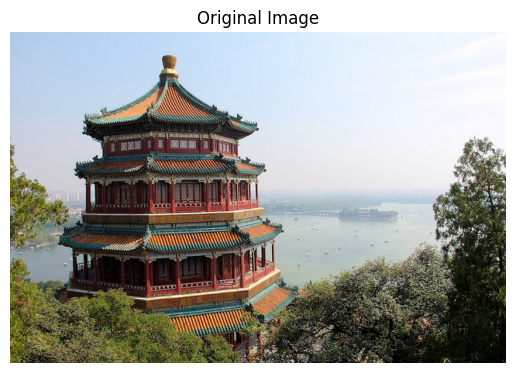

In [53]:
# Extra Material – Storing Images and Tensors in TFRecords
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [54]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("output/13_loading_preprocess_w_TF/my_image.tfrecord") as f:
    f.write(serialized_example)

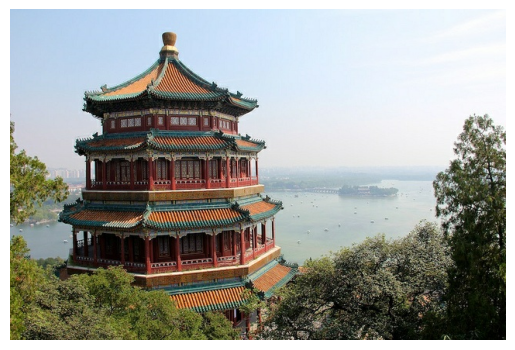

In [55]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,
                                                    feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])
    # or you can use tf.io.decode_image() instead

dataset = tf.data.TFRecordDataset("output/13_loading_preprocess_w_TF/my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [56]:
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [57]:
tf.io.parse_tensor(serialized, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [58]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x11\x08\x07a1@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [59]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\021\010\007a1@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [60]:
# Handling Lists of Lists Using the SequenceExample Protobuf
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [61]:
sequence_example

context {
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "content"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "shall"
          value: "we"
          value: "three"
          value: "meet"
          value: "again"
          value: "?"
        }
      }
      feature {
        bytes_list {
          value: "In"
          value: "thunder"
          value: ","
          value: "lightning"
          value: ","
          value: "or"
          value: "in"
          value: "rain"
          value: "?"
        }
      }
    }
  }
  feature_list {
    key: "c

In [62]:
serialized_sequence_example = sequence_example.SerializeToString()

context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [63]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

parsed_content

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>

In [64]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [65]:
print(parsed_feature_lists)

{'comments': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]], shape=(14, 2), dtype=int64), values=tf.Tensor(
[b'When' b'the' b'hurlyburly' b"'s" b'done' b'.' b'When' b'the' b'battle'
 b"'s" b'lost' b'and' b'won' b'.'], shape=(14,), dtype=string), dense_shape=tf.Tensor([2 8], shape=(2,), dtype=int64)), 'content': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [1 8]], shape=(16, 2), dtype=int64), values=tf.Tensor(
[b'When' b'shall' b'we' b'three' b'meet' b'again' b'?' b'In' b'thunder'
 b',' b'lightning' b',' b'or' b'in' b'rain' b'?'], shape=(16,), dtype=string), dense_shape=tf.Tensor([2 9], shape=(2,), dtype=int64))}


In [66]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


In [67]:
# Keras Preprocessing Layers
# The Normalization Layer

tf.random.set_seed(42)  # extra code – ensures reproducibility
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)  # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5069 - val_loss: 1.5981
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7331 - val_loss: 0.7075
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5930 - val_loss: 0.6851
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5760 - val_loss: 0.6582
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5674 - val_loss: 0.6438


In [68]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [69]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6187 - val_loss: 1.0202
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6700 - val_loss: 0.6306
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5783 - val_loss: 0.6421
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5666 - val_loss: 0.6344
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5604 - val_loss: 0.6277


In [70]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]  # pretend we have a few new instances (unscaled)
y_pred = final_model(X_new)  # preprocesses the data and makes predictions
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.8711716],
       [1.6645384],
       [2.634863 ]], dtype=float32)>

In [71]:
# extra code – creates a dataset to demo applying the norm_layer using map()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)

In [72]:
dataset = dataset.map(lambda X, y: (norm_layer(X), y))

In [73]:
list(dataset.take(1))  # extra code – shows the first batch

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397889, -1.0778131 , -0.9433854 ,  0.01485314,  0.02073333,
          -0.57291627,  0.9292612 , -1.4221537 ],
         [ 0.7519831 , -1.868895  ,  0.40547806, -0.23327684,  1.8614649 ,
           0.20516537, -0.9165477 ,  1.0966716 ],
         [-0.41469118,  0.02970133,  0.8180882 ,  1.0567837 , -0.0878671 ,
          -0.2998328 ,  1.3087282 , -1.697027  ],
         [ 1.7188957 , -1.3151377 ,  0.32664376, -0.2195511 , -0.33792186,
          -0.11146631, -0.9821345 ,  0.94174504],
         [-0.9620722 , -1.2360295 , -0.05625783, -0.03124396,  1.7090592 ,
          -0.30256987, -0.80411196,  1.3265638 ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

In [74]:
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()  # a small smoothing term
        return (inputs - self.mean_) / (self.std_ + eps)

In [75]:
my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

In [76]:
# The Discretization Layer
age = tf.constant([[10.], [93], [57.], [18], [37], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries = [18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int32, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int32)>

In [77]:
discretize_layer = tf.keras.layers.Discretization(num_bins = 3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int32, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int32)>

In [78]:
# The categoryEncoding Layer
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens = 3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [79]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [80]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens = 3 + 3)
onehot_layer(two_age_categories + [0, 3])   # add 3 to the second feature

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [81]:
# The StringLookup Layer
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

In [82]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

In [83]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"], ["Beijing"]])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])>

In [84]:
# extra code – an example using the IntegerLookup layer
ids = [123, 456, 789]
int_lookup_layer = tf.keras.layers.IntegerLookup()
int_lookup_layer.adapt(ids)
int_lookup_layer([[123], [456], [123], [111]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[3],
       [2],
       [3],
       [0]])>

In [85]:
# Hashing Layer
hashing_layer = tf.keras.layers.Hashing(num_bins = 10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["New York"], ["Montreal"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [8],
       [1]])>

In [86]:
# Encoding Categorical Features Using Embeddings
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim = 5, output_dim = 2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.00586119,  0.03454046],
       [-0.02694662, -0.03728934],
       [-0.00586119,  0.03454046]], dtype=float32)>

In [87]:
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),  # WORKAROUND
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.00603054, -0.01895652],
       [ 0.00507925, -0.04151434],
       [-0.00603054, -0.01895652]], dtype=float32)>

In [88]:
# extra code – set seeds and generates fake random data
# (feel free to load the real dataset if you prefer)
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000).astype(object)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000).astype(object)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input) 
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1398 - val_loss: 0.1077
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0967 - val_loss: 0.0925
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0880 - val_loss: 0.0869
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0848 - val_loss: 0.0847
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0837 - val_loss: 0.0838


In [89]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat (InputLayer)    │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num (InputLayer)    │ (None, 8)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 2)         │         12 │ cat[0][0]         │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ num[0][0],        │
│ (Concatenate)       │                   │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         11 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25 (104.00 B)

 Trainable params: 23 (92.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [90]:
# extra code – shows that the model can also be trained using a tf.data.Dataset
train_set = tf.data.Dataset.from_tensor_slices(((X_train_num, X_train_cat), y_train)).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices(((X_valid_num, X_valid_cat), y_valid)).batch(32)
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0832 - val_loss: 0.0834
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0830 - val_loss: 0.0832
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0829 - val_loss: 0.0831
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0829 - val_loss: 0.0830
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0828 - val_loss: 0.0830


In [91]:
# Text Preprocessing
train_data = ["To be", "!(to be)", "That's a question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [5, 2, 1, 2]])>

In [92]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode = "tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 1.0986123 ,
        0.        ]], dtype=float32)>

In [93]:
2 * np.log(1 + 4 / (1 + 3))

1.3862943611198906

In [94]:
# Using Pretraining Language Model Components
import tensorflow_hub as hub
import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated")
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

/home/fliu2/.local/share/pipx/venvs/jupyterlab/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

In [95]:
# Image Preprocessing Layers
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

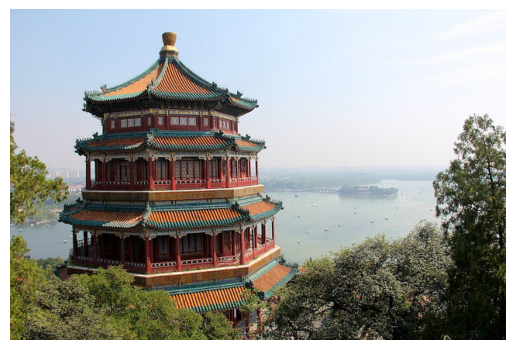

In [96]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

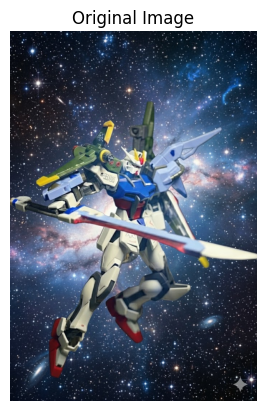

In [97]:
# extra code processing my own picture
my_img = tf.io.decode_png(tf.io.read_file("datasets/personbufs/gundam2.jpg"))
plt.imshow(my_img)
plt.axis("off")
plt.title("Original Image")
plt.show()

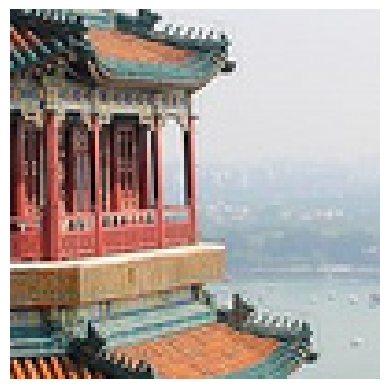

In [98]:
plt.imshow(cropped_images[0] / 255)
plt.axis("off")
plt.show()

In [99]:
# TensorFlow Datasets
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [100]:
for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]
    # [...] do something with the images and labels

In [101]:
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [102]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8355 - loss: 10.0024 - val_accuracy: 0.8787 - val_loss: 5.8259
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8787 - loss: 5.7659 - val_accuracy: 0.8738 - val_loss: 5.8657
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8835 - loss: 5.3290 - val_accuracy: 0.8787 - val_loss: 5.9952
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8866 - loss: 5.0978 - val_accuracy: 0.8953 - val_loss: 5.5695
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8881 - loss: 4.9613 - val_accuracy: 0.8710 - val_loss: 6.1359
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8777 - loss: 5.9299


In [103]:
# Exercise 9 Load the Fashion MNIST dataset, split, shuffle and save them into TFRecord files.
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [104]:
tf.random.set_seed(42)
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [105]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [106]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "label"
    value {
      int64_list {
        value: 9
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\

In [107]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["output/13_loading_preprocess_w_TF/{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [108]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

In [109]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [110]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

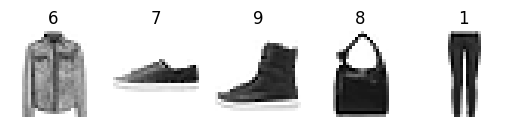

In [111]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [112]:
tf.random.set_seed(42)

standardization = tf.keras.layers.Normalization()

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = [28, 28]),
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [113]:
from datetime import datetime

logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/5
   1715/Unknown 6s 3ms/step - accuracy: 0.7999 - loss: 0.5689

/home/fliu2/.local/share/pipx/venvs/jupyterlab/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8375 - loss: 0.4559 - val_accuracy: 0.8760 - val_loss: 0.3615
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8758 - loss: 0.3394 - val_accuracy: 0.8782 - val_loss: 0.3421
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8880 - loss: 0.3028 - val_accuracy: 0.8754 - val_loss: 0.3535
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8979 - loss: 0.2770 - val_accuracy: 0.8856 - val_loss: 0.3252
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9053 - loss: 0.2556 - val_accuracy: 0.8890 - val_loss: 0.3251


In [114]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

In [115]:
# Exercise 10 Download Internet Movie Review Dataset, split, and preprocess it
from pathlib import Path

root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename, root + filename, extract=True,
                                   cache_dir=".")
if "_extracted" in filepath:
    path = Path(filepath) / "aclImdb"
else:
    path = Path(filepath).with_name("aclImdb")

In [116]:
# define a tree() function to view the structure of the aclImdb directory:
def tree(path, level=0, indent=4, max_files=3):
    if level == 0:
        print(f"{path}/")
        level += 1
    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]
    indent_str = " " * indent * level
    for sub_dir in sub_dirs:
        print(f"{indent_str}{sub_dir.name}/")
        tree(sub_dir,  level + 1, indent)
    for filepath in filepaths[:max_files]:
        print(f"{indent_str}{filepath.name}")
    if len(filepaths) > max_files:
        print(f"{indent_str}...")

tree(path)

datasets/aclImdb_v1_extracted/aclImdb/
    test/
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
    train/
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
    README
    imdb.vocab
    imdbEr.txt


In [117]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

In [118]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [119]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [120]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b'The back of the DVD box says Ellen Page co-stars in this movie. She does not even appear until two thirds of the movie is over and then its in minor role. I don\'t consider it a supporting role either, but rather a "bit" part. Also the plot has many unexplained elements. Some examples are: why does the main character reject her oldest son? Why does her youngest son drive head on into the train? He says its for a "sucker" bet which doesn\'t explain anything. Obviously the screenwriter doesn\'t know the definition of a sucker bet. This film is not worthy of the rental price in my opinion. Save your money and view it for free on TV if you think it needs to be seen.', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b"The best thing about camp films in general is that you know what to expect. It's like watching a professional wrestling match or a day time soap opera or a Jerry Springer show: you immediately can follow the skimpy plot, identify the cardboar

In [121]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

40.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [122]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [123]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [124]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

40.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [125]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000, seed=42)
train_set = train_set.batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

In [126]:
max_tokens = 1000
sample_reviews = train_set.map(lambda review, label: review)
text_vectorization = tf.keras.layers.TextVectorization(max_tokens=max_tokens, output_mode="tf_idf")
text_vectorization.adapt(sample_reviews)

In [127]:
text_vectorization.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

In [129]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
    778/Unknown 6s 4ms/step - accuracy: 0.7811 - loss: 0.4841

/home/fliu2/.local/share/pipx/venvs/jupyterlab/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8217 - loss: 0.4252 - val_accuracy: 0.8489 - val_loss: 0.3690
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8530 - loss: 0.3707 - val_accuracy: 0.8470 - val_loss: 0.3641
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8665 - loss: 0.3301 - val_accuracy: 0.8459 - val_loss: 0.3742
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8857 - loss: 0.2816 - val_accuracy: 0.8395 - val_loss: 0.3858
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9106 - loss: 0.2253 - val_accuracy: 0.8488 - val_loss: 0.3838


In [130]:
# Add an Embedding
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

In [131]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

In [132]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

In [133]:
# Add embedding
embedding_size = 20
tf.random.set_seed(42)

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int")
text_vectorization.adapt(sample_reviews)

model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True),  # <pad> tokens => zero vectors
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [134]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5


/home/fliu2/.local/share/pipx/venvs/jupyterlab/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.6288 - loss: 0.6307 - val_accuracy: 0.6795 - val_loss: 0.5491
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7666 - loss: 0.4956 - val_accuracy: 0.8033 - val_loss: 0.4263
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7948 - loss: 0.4442 - val_accuracy: 0.8489 - val_loss: 0.3885
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8093 - loss: 0.4176 - val_accuracy: 0.6587 - val_loss: 0.7280
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8186 - loss: 0.4123 - val_accuracy: 0.8299 - val_loss: 0.3825


In [135]:
# Use TFDS to load the same dataset more easily: tfds.load("imdb_reviews").
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
